In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from termcolor import colored
import os
import warnings
import random
import shutil
import cv2
import splitfolders
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import gc

In [129]:
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

In [130]:
working_dir = 'C:\\envs\\Working\\Iranian_Plates'
alphabet_base = 'C:\\envs\\DataSets\\large-dataset-of-persian-license-plate-characters\\chars\\'

In [131]:
alphabet_classes = os.listdir(alphabet_base)
print(f'Number of folders in ALPHABET-DIR : {len(alphabet_classes)}')

Number of folders in ALPHABET-DIR : 24


## Copy

In [5]:
# make a directory for alphabet images in working-dir
alphabet_dir = os.path.join(working_dir, 'alphabet')

if not os.path.exists(alphabet_dir) :
    os.mkdir(alphabet_dir)

In [6]:
# def Copy_Alphabet_Chars() :
#     for class_name in tqdm(alphabet_classes) :
#         # read class name and change it
#         new_name = 'char_'+class_name
#         # Create new class name in working dir
#         dest_class_path = os.path.join(alphabet_dir, new_name)
#         os.mkdir(dest_class_path)

#         # read images from source dir
#         class_path = os.path.join(alphabet_base, class_name)
#         class_path = os.path.join(class_path, '2')
#         class_files = [file_name for file_name in os.listdir(class_path) if file_name.endswith('.jpg')]
#         # Loop over source folders and copy to destinations
#         for img in class_files :
#             src = os.path.join(class_path, img)
#             dst = os.path.join(dest_class_path, img)
#             shutil.copy(src=src, dst=dst)

# Copy_Alphabet_Chars()

100%|██████████| 24/24 [00:12<00:00,  1.92it/s]


In [7]:
# Re-Define aplhabet-classes with copyed foders
alphabet_classes = os.listdir(alphabet_dir)

# Convert to Gray-Scale

In [64]:
# def Convert_Colored_To_GrayScale() :
#     '''
#     Convert Colored images to GrayScale .
#     '''

#     for class_name in tqdm(alphabet_classes) :
#         class_path = os.path.join(alphabet_dir, class_name)
#         class_images = [os.path.join(class_path, file_name) for file_name in os.listdir(class_path)]


#         for image_path in class_images :
#             img = cv2.imread(image_path, 0)
#             cv2.imwrite(image_path, img)

# Convert_Colored_To_GrayScale()

100%|██████████| 24/24 [01:24<00:00,  3.50s/it]


# Plot Counts of files

In [65]:
def Counts_Of_Files(alphabet_dir) :
    '''
    Counts number of files in each directory and stored in a List
    '''
    counts = []
    # alphabet_classes = os.listdir(alphabet_dir)

    for class_name in alphabet_classes :
        class_path = os.path.join(alphabet_dir, class_name)
        count = len(os.listdir(class_path))
        counts.append(count)
    return counts

counts = Counts_Of_Files(alphabet_dir)

In [66]:
print(f'Number of all images : {sum(counts)}')

Number of all images : 20145


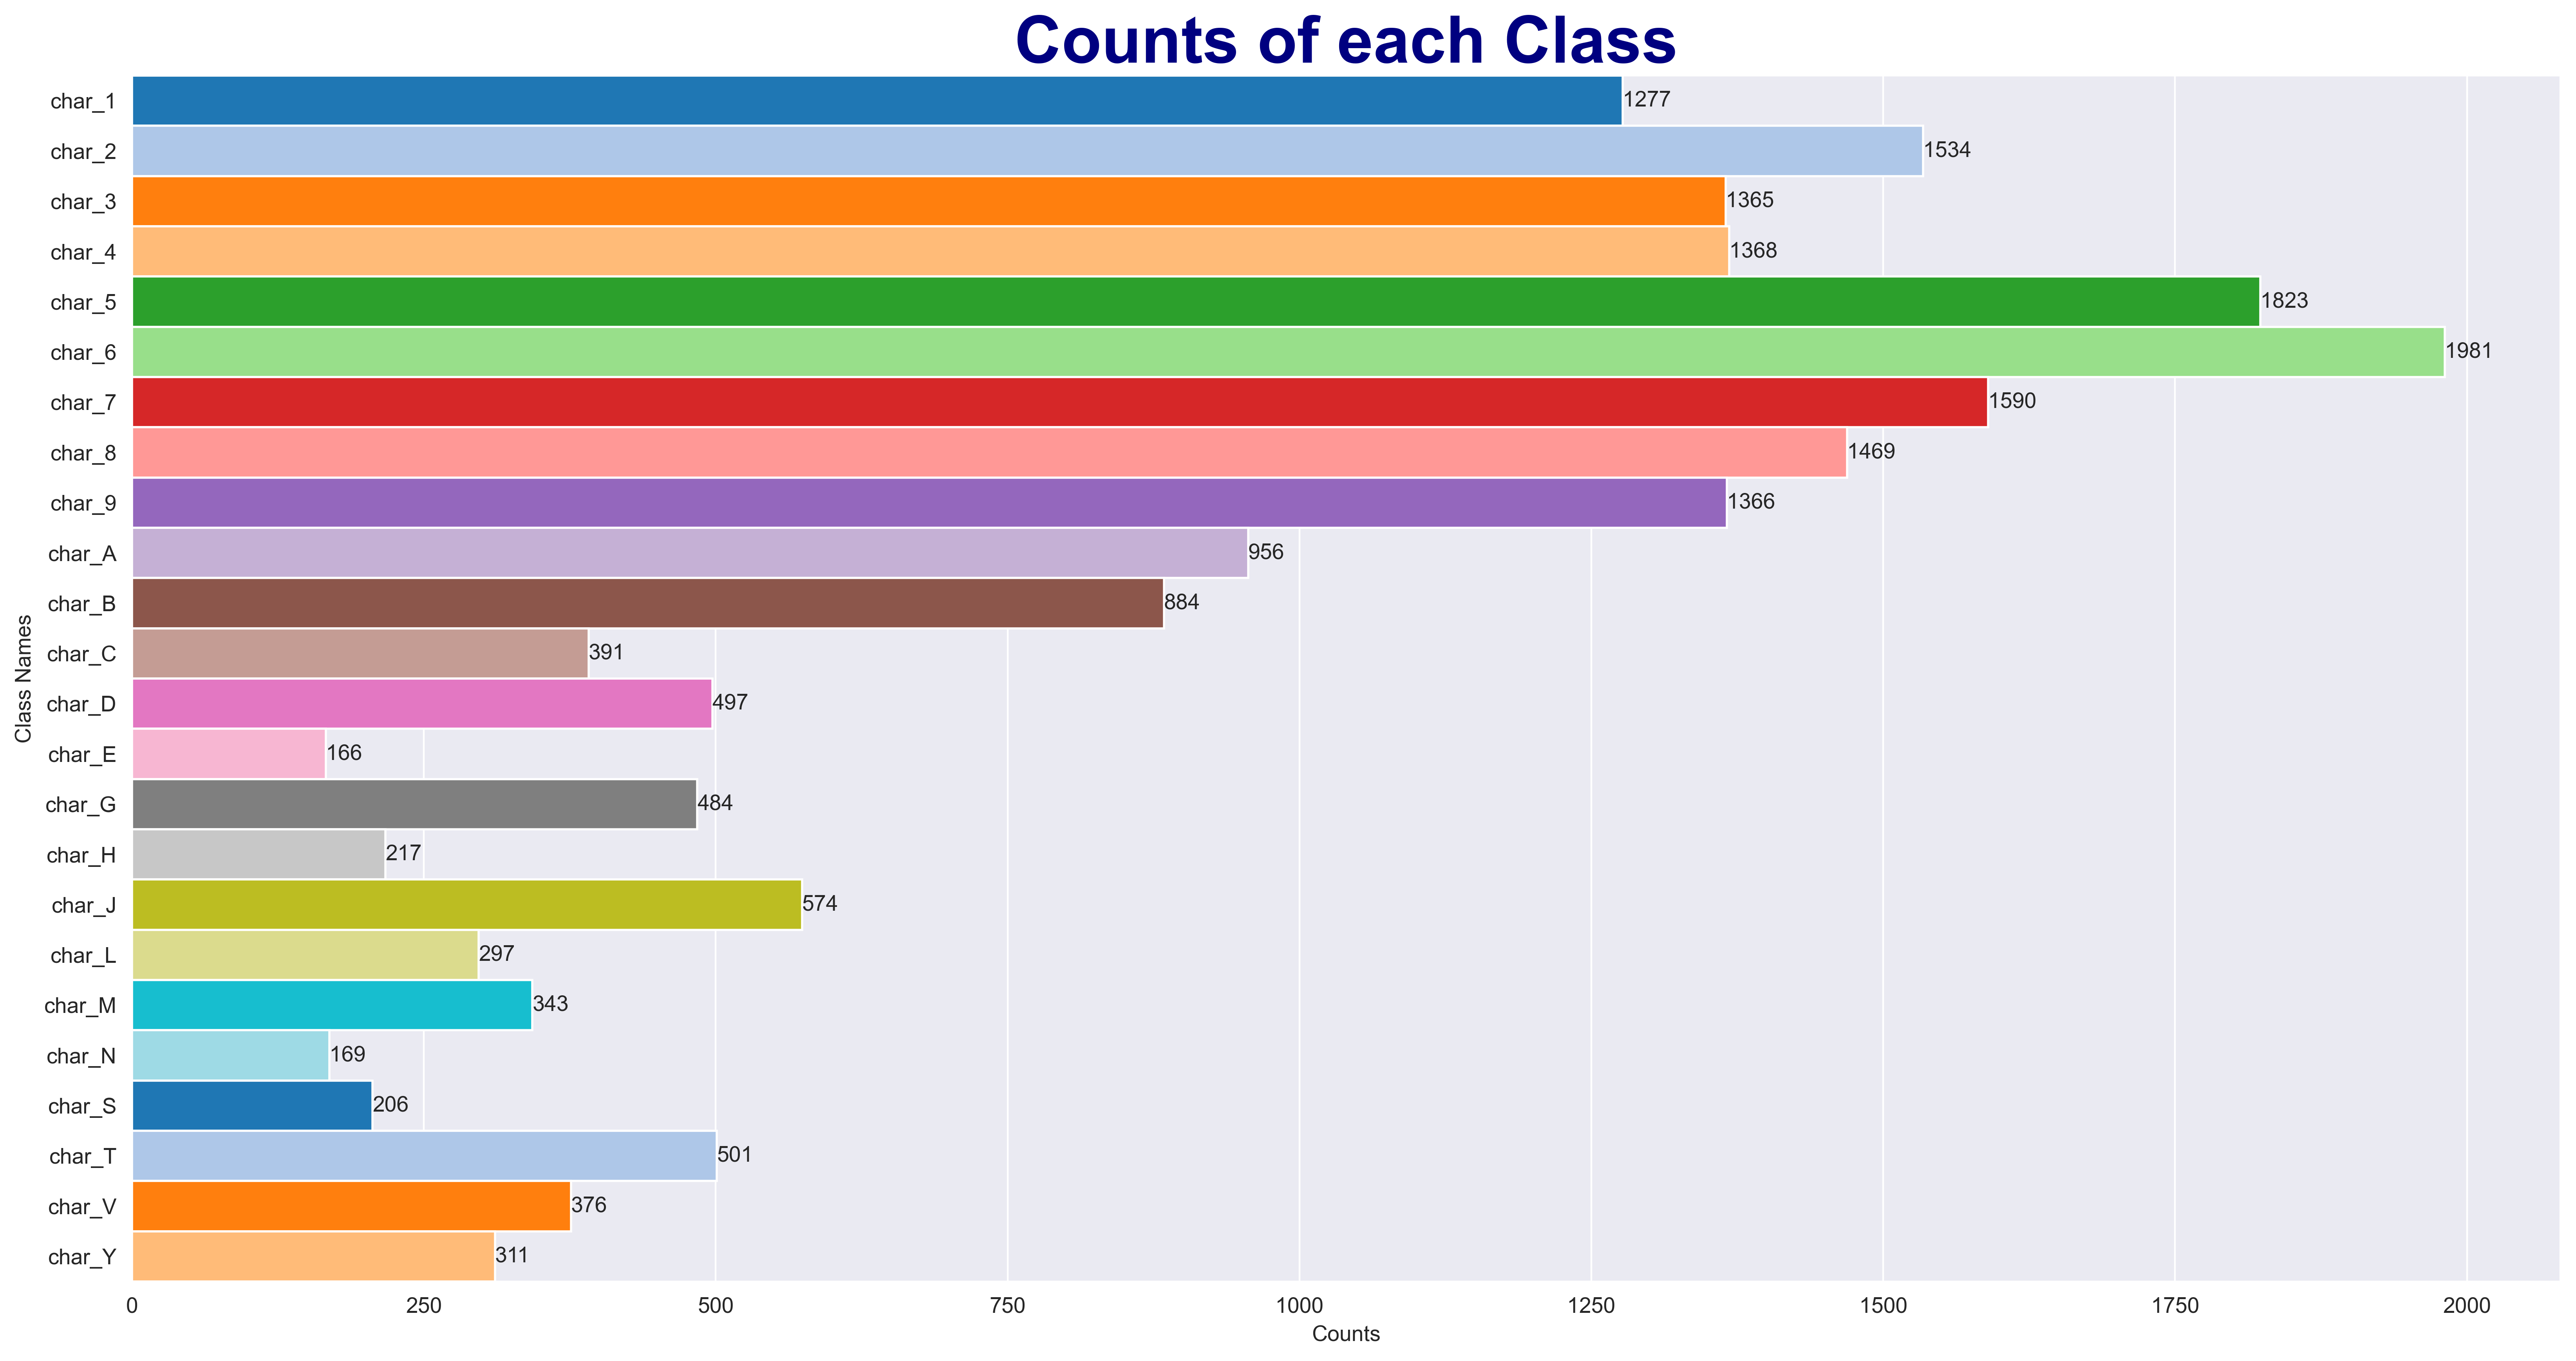

In [67]:
plt.figure(figsize=(20, 10), dpi=400)
ax = sns.barplot(x=counts, hue=alphabet_classes,y=alphabet_classes, palette='tab20', saturation=1.0, width=1.0)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Counts of each Class', fontsize=30, fontweight='bold', c='navy')
plt.ylabel('Class Names')
plt.xlabel('Counts')
plt.show()

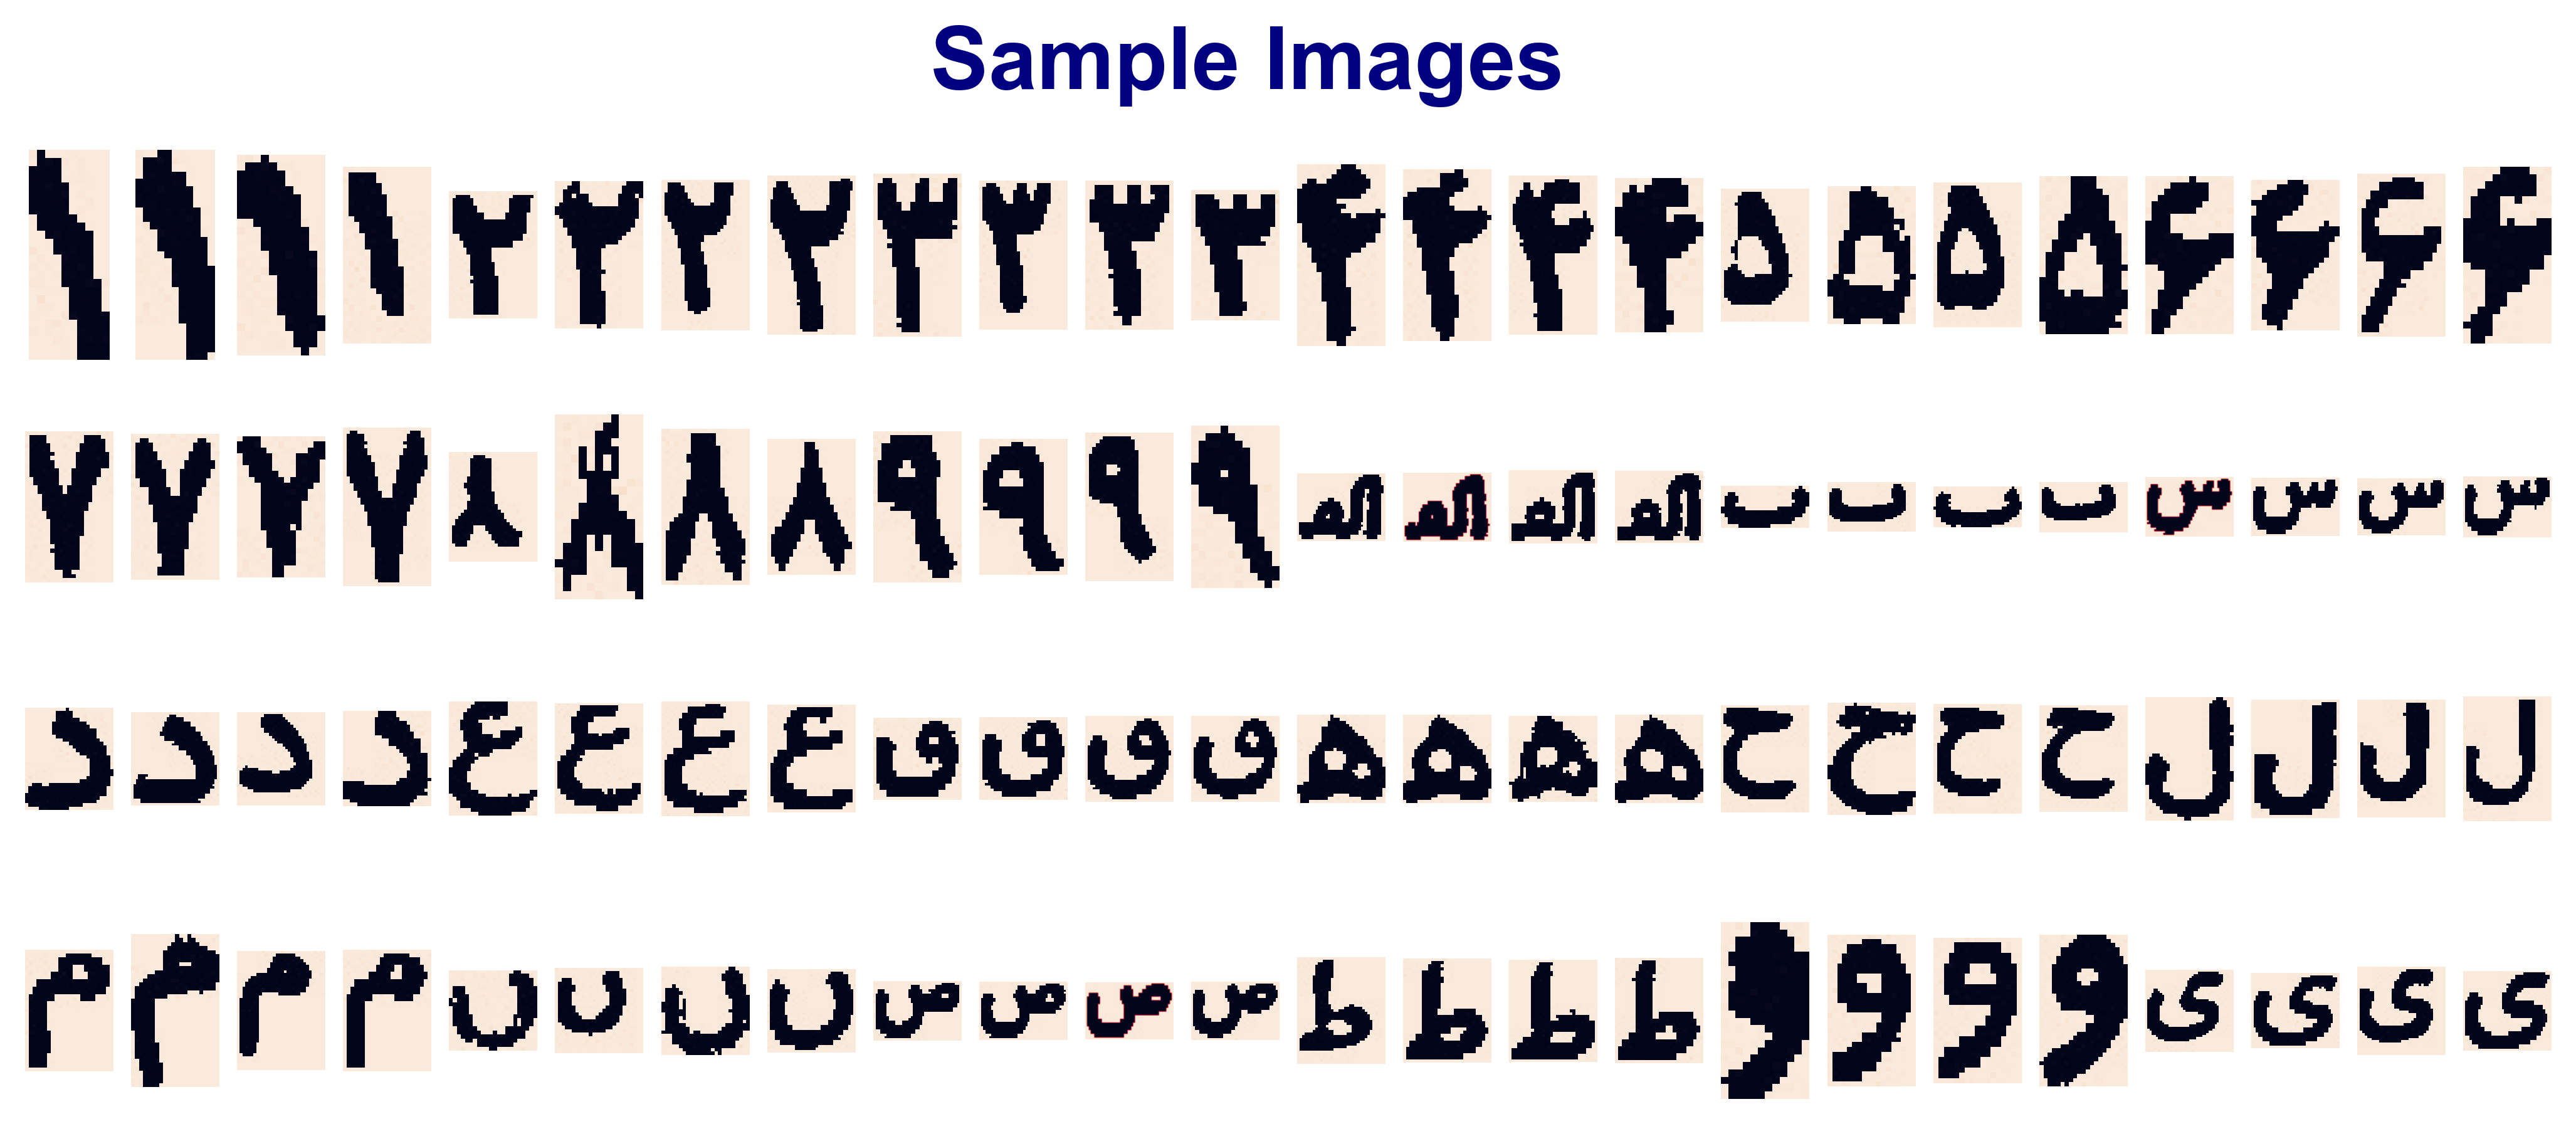

In [68]:
def Plot_Sample_Images() :
    all_images = []
    # alphabet_classes = os.listdir(alphabet_dir)

    for class_name in alphabet_classes :
        class_path = os.path.join(alphabet_dir, class_name)
        class_images = [os.path.join(class_path, file_name) for file_name in os.listdir(class_path)]
        random_images = random.choices(class_images, k=4)
        all_images.extend(random_images)
        
    plt.figure(figsize=(13, 5), dpi=400)
    plt.suptitle('Sample Images', fontsize=25, fontweight='bold', c='navy')
    for i in range(len(all_images)):
        plt.subplot(4, 24, i+1)
        img = plt.imread(all_images[i])
        plt.axis('off')
        plt.imshow(img)
    plt.show()

Plot_Sample_Images()

# Image_size

In [69]:
def Fetch_Image_Sizes() :
    '''
    A function to fetch all of images sizes and stored in a Set variable
    '''
    img_sizes = set()

    for class_name in tqdm(alphabet_classes) :
        class_path = os.path.join(alphabet_dir, class_name)
        class_files_path = [os.path.join(class_path, file_name) for file_name in os.listdir(class_path) if file_name.endswith('.jpg')]
        for image_path in class_files_path :
            img = cv2.imread(image_path)
            h, w, c = img.shape
            img_sizes.add((h, w, c))
    return img_sizes

img_sizes = Fetch_Image_Sizes()

100%|██████████| 24/24 [01:08<00:00,  2.87s/it]


In [76]:
if len(img_sizes) == 1 :
    print(f'There is a unique size of {img_sizes[0]} for all images.')
else :
    print(f'Tehre are {len(img_sizes)} different sizes for images.')

Tehre are 1147 different sizes for images.


In [77]:
min(img_sizes), max(img_sizes)

((8, 16, 3), (65, 40, 3))

In [86]:
h_mean = int(np.mean([min(img_sizes)[0], max(img_sizes)[0]]))
w_mean = int(np.mean([min(img_sizes)[1], max(img_sizes)[1]]))

img_size = (h_mean, w_mean)
print(f'Sellected size of images is mean of sizes, is {img_size}')

Sellected size of images is mean of sizes, is (36, 28)


# Split to train, valid, test

In [87]:
# Create a folder to store splited images
splited_alphabet = os.path.join(working_dir, 'splited_alphabet')

if not os.path.exists(splited_alphabet) :
    os.mkdir(splited_alphabet)

In [88]:
splitfolders.ratio(
    input=alphabet_dir,
    output=splited_alphabet,
    seed=42,
    ratio=(0.6, 0.2, 0.2)
)

Copying files: 20145 files [00:25, 794.11 files/s] 


In [89]:
def Count_images() :
    folders = os.listdir(splited_alphabet)
    print('Number of samples in each folder :')

    for folder in folders :
        count = 0
        folder_path = os.path.join(splited_alphabet, folder)
        for class_name in os.listdir(folder_path) :
            class_path = os.path.join(folder_path, class_name)
            count += len(os.listdir(class_path))
        print(f'{folder} : {count}')

Count_images()

Number of samples in each folder :
test : 4050
train : 12076
val : 4019


In [120]:
train_dir = os.path.join(splited_alphabet, 'train')
valid_dir = os.path.join(splited_alphabet, 'val')
test_dir = os.path.join(splited_alphabet, 'test')

# Augs = Blure, Add-Noise

In [91]:
def Blure_Filter(img, filter_type ="blur", kernel=3):
    '''
    ### Filtering ###
    img: image
    filter_type: {blur: blur, gaussian: gaussian, median: median}
    '''
    if filter_type == "blur":
        return cv2.blur(img,(kernel,kernel))
    
    elif filter_type == "gaussian":
        return cv2.GaussianBlur(img, (kernel, kernel), 0)
    
    elif filter_type == "median":
        return cv2.medianBlur(img, kernel)

In [92]:
def Add_Noise(img, noise_type="gauss"):
    '''
    ### Adding Noise ###
    img: image
    cj_type: {gauss: gaussian, sp: salt & pepper}
    '''
    if noise_type == "gauss": 
        mean=0
        st=0.5
        gauss = np.random.normal(mean,st,img.shape)
        gauss = gauss.astype('uint8')
        image = cv2.add(img,gauss)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        return image
    
    elif noise_type == "sp": 
        prob = 0.01
        black = np.array([0, 0, 0], dtype='uint8')
        white = np.array([255, 255, 255], dtype='uint8')

        probs = np.random.random(img.shape[:2])
        img[probs < (prob / 2)] = black
        img[probs > 1 - (prob / 2)] = white
        return img

In [99]:
sample_img = os.path.join(train_dir, 'char_H\\H_45339.jpg')
sample_img

'C:\\envs\\Working\\Iranian_Plates\\splited_alphabet\\train\\char_H\\H_45339.jpg'

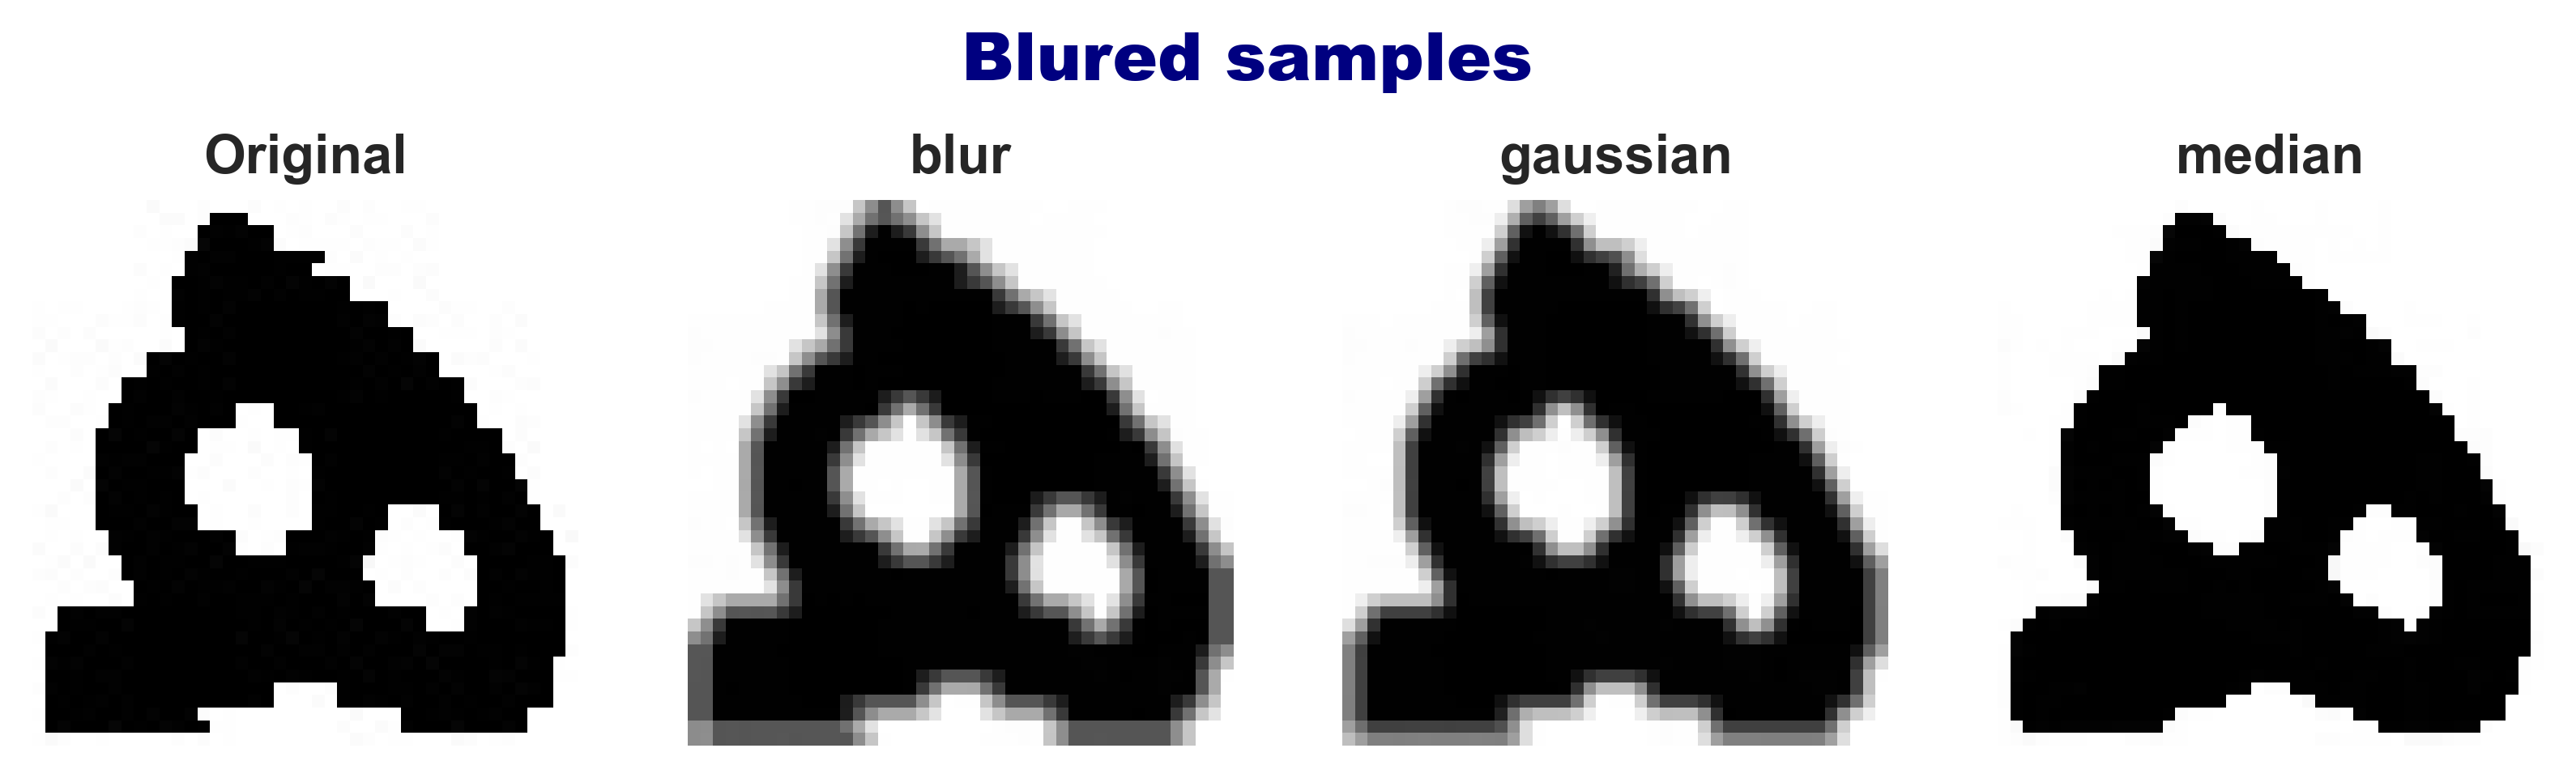

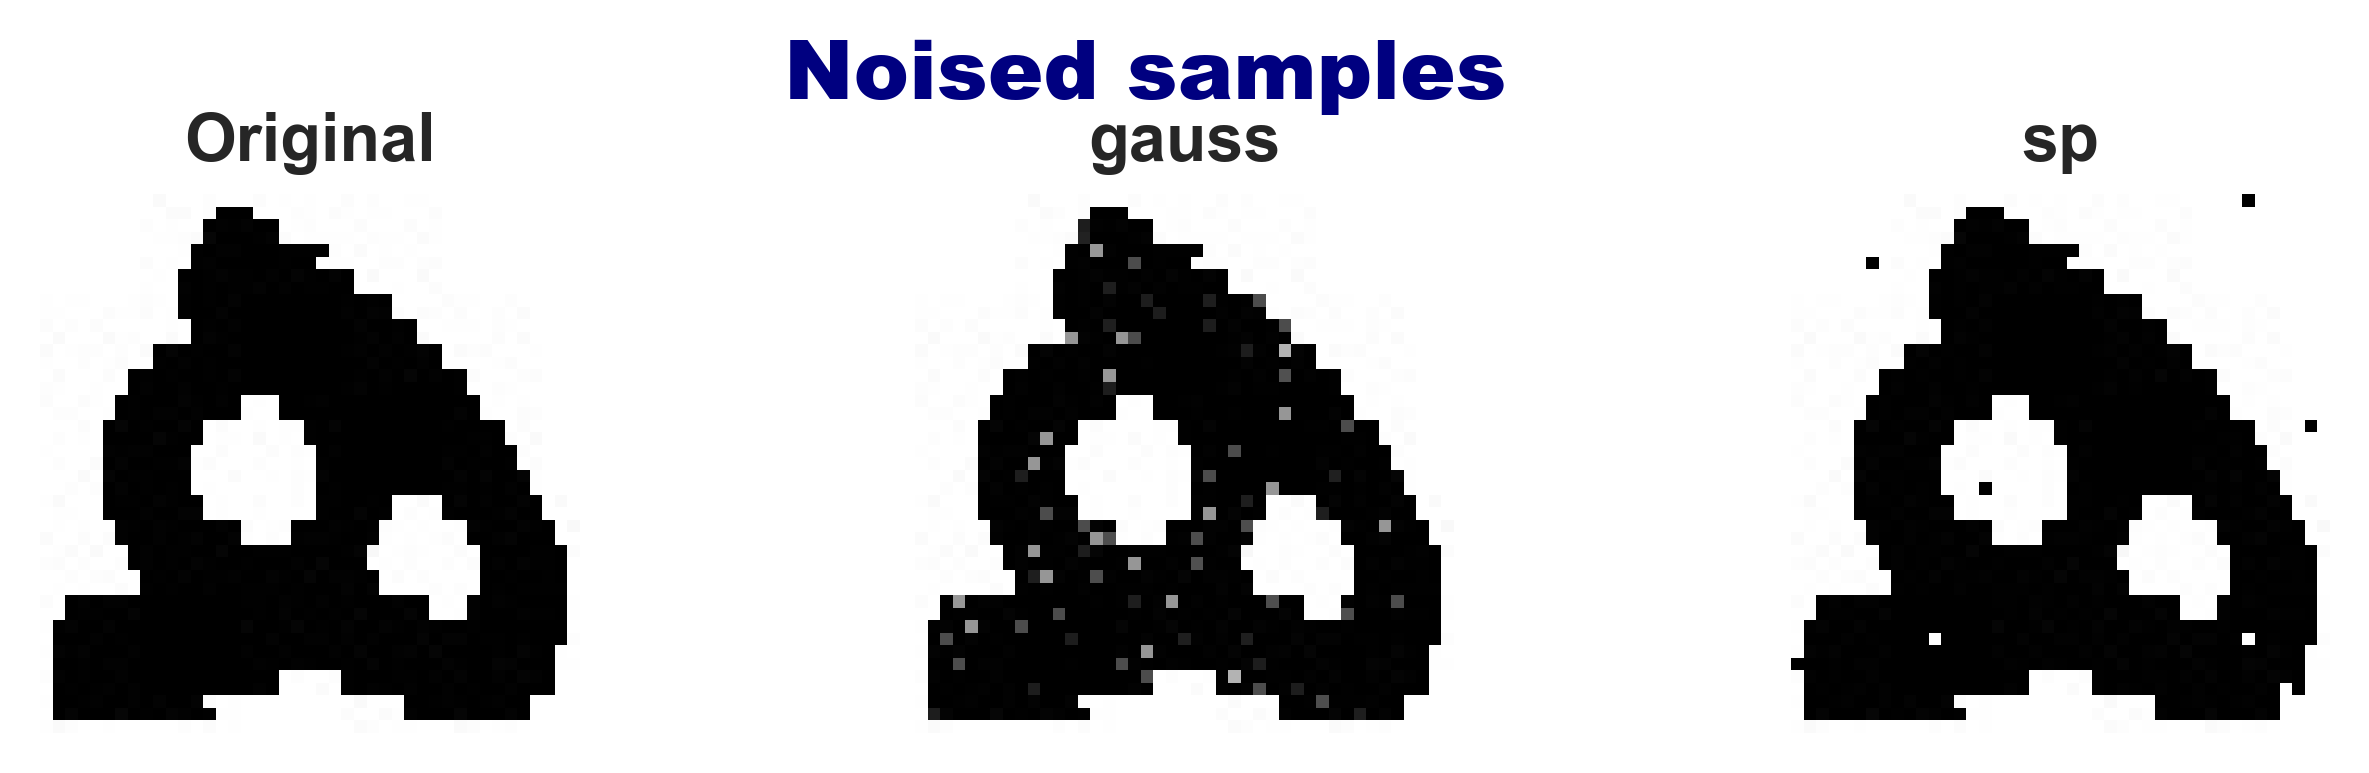

In [132]:
def Plot_AUGS_Samples():
    plt.figure(figsize=(10, 2.25), dpi=400)
    plt.suptitle('Blured samples', fontweight=900, fontsize=15, y=1.1, c='navy')
    # Original image
    plt.subplot(1, 4, 1)
    img = cv2.imread(sample_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Original', fontweight=800)
    # Blurs
    # List of filters
    filters = ['blur', 'gaussian', 'median']
    for filter in filters :
        indx = filters.index(filter)
        plt.subplot(1, 4, indx+2)
        filtered_img = Blure_Filter(img, filter_type=filter, kernel=3)
        plt.imshow(filtered_img)
        plt.axis('off')
        plt.title(filter, fontweight=800)

    plt.figure(figsize=(8,1.75), dpi=400)
    plt.suptitle('Noised samples', fontweight=900, fontsize=15, y=1.1, c='navy')
    plt.subplot(1, 3, 1)
    img = cv2.imread(sample_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Original', fontweight=800)

    noises = ['gauss', 'sp']
    for noise in noises :
        indx = noises.index(noise)
        plt.subplot(1, 3, indx+2)
        noised_img = Add_Noise(img, noise_type=noise)
        plt.imshow(noised_img, cmap='gray')
        plt.axis('off')
        plt.title(noise, fontweight=800)

Plot_AUGS_Samples()

In [101]:
def Augmentations(img) :
    ''' Apply random choice of augmentation functions on images '''

    returned_augs = dict()

    AUGS = ['Blure', 'Noise']

    # How many of Augs choosen ?
    random_num = random.randint(1, 2)
    random_choice = random.choices(AUGS, k=random_num)
    # To avoid repeatations :
    random_choice = list(set(random_choice))

    for choice in random_choice :
        if choice == 'Blure' :
            filters = ['blur', 'gaussian', 'median']
            kernel = 3
            random_filter = random.choices(filters, k=1)[0]
            blured_img =  Blure_Filter(img, filter_type=random_filter, kernel=kernel)
            new_name = '_blured'
            returned_augs[new_name] = blured_img


        elif choice == 'Noise' :
            noises = ['gauss', 'sp']
            random_noise = random.choices(noises, k=1)[0]
            noised_img = Add_Noise(img, noise_type=random_noise)
            new_name = '_noised'
            returned_augs[new_name] = noised_img
            
    return returned_augs

## apply aug to train_folder

In [135]:
def Count_Train_Images():
    '''
    A function to counts number of images in train folder
    '''
    num_images = 0

    for class_name in os.listdir(train_dir) :
        class_path = os.path.join(train_dir, class_name)
        num_images += len(os.listdir(class_path))
    
    return num_images

num_images_before_augs = Count_Train_Images()
print(f'Number of Train-images before Augmentations : {num_images_before_augs}')

Number of Train-images before Augmentations : 27216


In [103]:
def Apply_Augmentations():
    for class_name in os.listdir(train_dir) :
        class_path = os.path.join(train_dir, class_name)
        for file_name in tqdm(os.listdir(class_path)) :
            img_path = os.path.join(class_path, file_name)
            img = cv2.imread(img_path)
            returned = Augmentations(img)

            for exported_name, exported_image in returned.items() :
                # 1_left.jpg ---TO---> 1_lef_blured.jpg
                new_name = file_name.split('.')[0] + exported_name + '.' + file_name.split('.')[-1]
                new_path = os.path.join(class_path, new_name)
            
                # Save new image
                cv2.imwrite(new_path, exported_image) 

Apply_Augmentations()

100%|██████████| 186/186 [00:00<00:00, 215.84it/s]


In [136]:
num_images_after_augs = Count_Train_Images()
print(f'Number of Train-images before Augmentations : {num_images_after_augs}')

Number of Train-images before Augmentations : 27216


In [137]:
print(f'{num_images_after_augs - num_images_before_augs} images added by Data-Augmentations')

0 images added by Data-Augmentations


# DataSets and DataLoaders

In [108]:
batch_size = 64

In [106]:
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor()
])

In [124]:
############################| Train |############################
# Create Dataset from Images
train_ds = ImageFolder(root=train_dir, transform=transform)

# Create DataLoader from defined dataset
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

print('Train Dataset\n')
print(train_ds)
print()
print('Train DataLoader\n')
print(train_loader)
print('_'*100)
############################| Validation |############################
# Create Dataset from Images
valid_ds = ImageFolder(root=valid_dir, transform=transform)

# Create DataLoader from defined dataset
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

print('Validation Dataset\n')
print(valid_ds)
print()
print('Validation DataLoader\n')
print(valid_loader)
print('_'*100)
############################| Test |############################
# Create Dataset from Images
test_ds = ImageFolder(root=test_dir, transform=transform)

# Create DataLoader from defined dataset
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

print('Test Dataset\n')
print(test_ds)
print()
print('Test DataLoader\n')
print(test_loader)
print('_'*100)

Train Dataset

Dataset ImageFolder
    Number of datapoints: 27216
    Root location: C:\envs\Working\Iranian_Plates\splited_alphabet\train
    StandardTransform
Transform: Compose(
               Resize(size=(36, 28), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

Train DataLoader

____________________________________________________________________________________________________
Validation Dataset

Dataset ImageFolder
    Number of datapoints: 4019
    Root location: C:\envs\Working\Iranian_Plates\splited_alphabet\val
    StandardTransform
Transform: Compose(
               Resize(size=(36, 28), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

Validation DataLoader

____________________________________________________________________________________________________
Test Dataset

Dataset ImageFolder
    Number of datapoints: 4050
    Root location: C:\envs\Working\Iranian_Plates\splited_alph

In [125]:
# print shape of dataset for each set
for key, value in {'Train': train_loader, "Validation": valid_loader, 'Test': test_loader}.items():
    for X, y in value:
        print(colored(f'{key}:', 'white','on_green', attrs=['bold']))
        print(f"Shape of images [Batch_size, Channels, Height, Width]: {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        print('-'*45)
        break

Train:
Shape of images [Batch_size, Channels, Height, Width]: torch.Size([64, 3, 36, 28])
Shape of y: torch.Size([64]) torch.int64

---------------------------------------------
Validation:
Shape of images [Batch_size, Channels, Height, Width]: torch.Size([64, 3, 36, 28])
Shape of y: torch.Size([64]) torch.int64

---------------------------------------------
Test:
Shape of images [Batch_size, Channels, Height, Width]: torch.Size([64, 3, 36, 28])
Shape of y: torch.Size([64]) torch.int64

---------------------------------------------


# Space Freeup